# 5. Quantum Algorithms: Phase estimation

<Admonition type="note">

Kento Ueda (May 15, 2024)

This notebook provides the fundamental concepts and implementation of the Quantum Fourier Transformation (QFT) and Quantum Phase Estimation (QPE).

PDFs of lecture notes will be available soon and please note that some code snippets may become deprecated since these are static images.

*Approximate QPU time to run this experiment is 7 seconds.*

</Admonition>

## 1. Introduction

**Quantum Fourier Transformation (QFT)**

The Quantum Fourier Transformation is the quantum counterpart of the classical discrete Fourier transform. It is a linear transformation applied to the quantum states, mapping computational bases into their Fourier basis representations. The QFT plays a key role in many quantum algorithms, offering an efficient method to extract periodicity information from quantum states.
The QFT can be implemented with $O(N^2)$ operations with quantum gates such as Hadamard gates and Control-Phase gates for $N$ qubits, enabling exponential speedup over classical Fourier transformation.

- **Applications**: It is a foundational part in quantum algorithms such as Shor's algorithm for factoring large integers and discrete logarithm.


**Quantum Phase Estimation (QPE)**

Quantum Phase Estimation is a quantum algorithm used to estimate the phase associated with an eigenvector of a unitary operator. This algorithm provides a bridge between the abstract mathematical properties of quantum states and their computational applications.


- **Applications**: It can solve problems such as finding eigenvalues of unitary matrices and simulating quantum systems.


Together, QFT and QPE form the essential backbone of many quantum algorithms solving problems that are infeasible for classical computers. By the end of this notebook, you will gain an understanding of how these techniques are implemented.

## 2. Basic of Quantum Fourier Transformation (QFT)

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler

from numpy import pi

From the analogy with the discrete Fourier transform, the QFT acts on a quantum state $\vert X\rangle = \sum_{j=0}^{N-1} x_j \vert j \rangle$ for $N$ qubits and maps it to the quantum state $\vert Y\rangle = \sum_{k=0}^{N-1} y_k \vert k \rangle$.


$$
QFT_{N}: \vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle
$$

where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.


Or the unitary matrix representation:


$$
U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert
$$

### 2.1. Intuition <a id="intuition"></a>

The quantum Fourier transform (QFT) transforms between two bases, the computational (Z) basis, and the Fourier basis. But what does the Fourier basis mean in this context? You likely recall that the Fourier transform $F(\omega)$ of a function $f(x)$ describes the convolution of $f(x)$ onto a sinusoidal function with frequency $\omega$. In Layman's terms: the Fourier transform is a function describing how much of each frequency $\omega$ we would need to build up a function $f(x)$ out of sine functions (or cosine functions). To get a better sense for what the QFT means in this context, consider the stepped images below which show a number encoded in binary, using four qubits:

In the computational basis, we store numbers in binary using the states $|0\rangle$ and $|1\rangle$:

![zbasis-counting.gif](https://learning-api.quantum.ibm.com/assets/3e5218f9-5abd-4d7b-8637-a3de773aa7cd?format=auto&quality=80)

Note the frequency with which the different qubits change; the leftmost qubit flips with every increment in the number, the next with every 2 increments, the third with every 4 increments, and so on.

If we apply a quantum Fourier transform to these states, we map
$$
|\text{State in Computational Basis}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{State in Fourier Basis}\rangle
$$

$$
\text{QFT}|x\rangle = |\widetilde{x}\rangle
$$

(We often denote states in the Fourier basis using the tilde (~)).

In the Fourier basis, we store numbers using different rotations around the Z-axis:

![fourierbasis-counting.gif](https://learning-api.quantum.ibm.com/assets/aac18049-a467-4822-947d-cdca57ad8f31?format=auto&quality=80)

The number we want to store dictates the angle at which each qubit is rotated around the Z-axis. In the state $|\widetilde{0}\rangle$, all qubits are in the state $|{+}\rangle$. As seen in the example above, to encode the state $|\widetilde{5}\rangle$ on 4 qubits, we rotated the leftmost qubit by $\tfrac{5}{2^n} = \tfrac{5}{16}$ full turns ($\tfrac{5}{16}\times 2\pi$ radians). The next qubit is turned double this ($\tfrac{10}{16}\times 2\pi$ radians, or $10/16$ full turns), this angle is then doubled for the qubit after, and so on.

Again, note the frequency with which each qubit changes. The leftmost qubit (`qubit 0`) in this case has the lowest frequency, and the rightmost the highest.
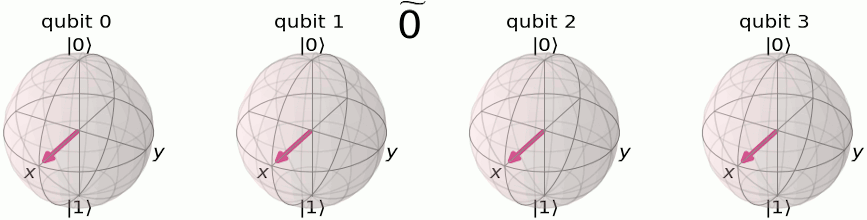
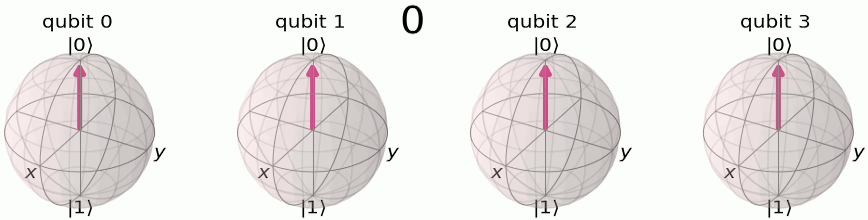

### 2.2 Example: 1-qubit QFT

Let's consider the case of $N = 2^1 = 2$.

The unitary matrix can be written:

$$
\begin{aligned}
U_{QFT} & = \frac{1}{\sqrt{2}} \sum_{j=0}^{1} \sum_{k=0}^{1} \omega_2^{jk} \vert k \rangle \langle j \vert
\\
& = \frac{1}{\sqrt{2}} (\omega_2^{0} \vert 0 \rangle \langle 0 \vert + \omega_2^{0} \vert 0 \rangle \langle 1 \vert + \omega_2^{0} \vert 1 \rangle \langle 0 \vert + \omega_2^{1} \vert 1 \rangle \langle 1 \vert)
\\
& = \frac{1}{\sqrt{2}} (\vert 0 \rangle \langle 0 \vert + \vert 0 \rangle \langle 1 \vert + \vert 1 \rangle \langle 0 \vert - \vert 1 \rangle \langle 1 \vert)
\\
& = H
\end{aligned}
$$

This operation is the result of applying the Hadamard gate($H$).

### 2.3 Product representation of QFT

Let's generalize a transformation for $N = 2^n$, $QFT_{N}$ acting on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$.
$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials,}
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding}
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1}
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
\end{aligned}
$$

### 2.4 Example: Circuit construction of 3 qubits QFT

From the above description, it may not be clear how to construct a QFT circuit. For now, simply note that we expect three qubits to have phases that evolve at different "rates". Understand exactly how this is translated into a circuit is left as an exercise to the reader. There are multiple diagrams and examples in the lecture pdf. Additional resources include [this lesson](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring) from [Fundamentals of Quantum Algorithms](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms).

We will demonstrate QFT using simulators, only. So will not use the Qiskit patterns framework, until we move on to quantum phase estimation.

In [3]:
# Prepare for 3 qubits circuit
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

In [4]:
qc.h(2)
qc.cp(pi / 2, 1, 2)  # Controlled-phase gate from qubit 1 to qubit 2
qc.cp(pi / 4, 0, 2)  # Controlled-phase gate from qubit 0 to qubit 2
qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/98cc96b3-f2d8-4d0d-bb57-186ea0919f53-0.avif" alt="Output of the previous code cell" />

In [5]:
qc.h(1)
qc.cp(pi / 2, 0, 1)  # Controlled-phase gate from qubit 0 to qubit 1

qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/eaff67fa-82f9-4402-8fa5-d0f0af824616-0.avif" alt="Output of the previous code cell" />

In [6]:
qc.h(0)

qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/43e09a6b-ea86-4f02-9e3a-82317c3b787f-0.avif" alt="Output of the previous code cell" />

In [7]:
qc.swap(0, 2)

qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/d7dd1cae-f463-4308-866c-8267e015c6ff-0.avif" alt="Output of the previous code cell" />

We try to apply QFT to $|5\rangle$ as an example.

First, we confirm the binary notation of the integer 5 and create the circuit encoding the state 5:

In [8]:
bin(5)

'0b101'

In [9]:
qc = QuantumCircuit(3)

qc.x(0)
qc.x(2)
qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/db631de5-4619-4e8c-b9d1-c6197650ae33-0.avif" alt="Output of the previous code cell" />

We check the quantum states using the Aer simulator:

In [10]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/83f34fc7-21f3-408b-9beb-a146cb77d27c-0.avif" alt="Output of the previous code cell" />

Finally, we add QFT and view the final state of our qubits:

In [11]:
qc.h(2)
qc.cp(pi / 2, 1, 2)
qc.cp(pi / 4, 0, 2)

qc.h(1)
qc.cp(pi / 2, 0, 1)

qc.h(0)

qc.swap(0, 2)

qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/524f24ae-3d86-4be4-99cc-c0c8557b8393-0.avif" alt="Output of the previous code cell" />

In [12]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/cf4d7152-bb06-4017-922a-5fa97075a67f-0.avif" alt="Output of the previous code cell" />

We can see out QFT function has worked correctly. Qubit 0 has been rotated by $\tfrac{5}{8}$ of a full turn, qubit 1 by $\tfrac{10}{8}$ full turns (equivalent to $\tfrac{1}{4}$ of a full turn), and qubit 2 by $\tfrac{20}{8}$ full turns (equivalent to $\tfrac{1}{2}$ of a full turn).

### 2.5 Exercise: QFT

(1) Implement QFT of 4 qubits.

In [13]:
##your code goes here##

(2) Apply QFT to $|14\rangle$, simulate and plot the statevector using the Bloch sphere.

In [14]:
##your code goes here##

#### Solution of the exercise: QFT

(1)

In [13]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr, cr)

qc.h(3)
qc.cp(pi / 2, 2, 3)
qc.cp(pi / 4, 1, 3)
qc.cp(pi / 8, 0, 3)

qc.h(2)
qc.cp(pi / 2, 1, 2)
qc.cp(pi / 4, 0, 2)

qc.h(1)
qc.cp(pi / 2, 0, 1)

qc.h(0)

qc.swap(0, 3)
qc.swap(1, 2)

qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/02e1d50b-6555-4a1e-a2b9-ba77c77840a1-0.avif" alt="Output of the previous code cell" />

(2)

In [14]:
bin(14)

'0b1110'

In [15]:
qc = QuantumCircuit(4)

qc.x(1)
qc.x(2)
qc.x(3)
qc.draw("mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/a01ee72e-8486-426d-a654-21b272b958ff-0.avif" alt="Output of the previous code cell" />

In [16]:
qc.h(3)
qc.cp(pi / 2, 2, 3)
qc.cp(pi / 4, 1, 3)
qc.cp(pi / 8, 0, 3)

qc.h(2)
qc.cp(pi / 2, 1, 2)
qc.cp(pi / 4, 0, 2)

qc.h(1)
qc.cp(pi / 2, 0, 1)
qc.h(0)

qc.swap(0, 3)
qc.swap(1, 2)

qc.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/db8a6229-a864-4f5e-889b-8ccd5561eddb-0.avif" alt="Output of the previous code cell" />

In [17]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/0d0af6c8-73e7-4e49-9d81-75446373d6c8-0.avif" alt="Output of the previous code cell" />

## 3. Basic of Quantum Phase Estimation (QPE)

Given a unitary operation $U$, the QPE estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$ since $U$ is unitary, all of its eigenvalues have a norm of 1.

### 3.1 Procedure

#### 1. Setup
$\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form the counting register on which we will store the value $2^n\theta$:

$$
|\psi_0\rangle = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle
$$

#### 2. Superposition

Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register:



$$
|\psi_1\rangle = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle
$$

#### 3. Controlled Unitary operations

We need to introduce the controlled unitary $CU$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operator with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means:



$$
U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle
$$

### 3.2 Example: T-gate QPE

Let's use $T$ gate as an example of QPE and estimate its phase $\theta$.

$$
T|1\rangle =
\begin{pmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{pmatrix}
\begin{pmatrix}
0\\
1\\
\end{pmatrix}
= e^\frac{i\pi}{4}|1\rangle
$$

We expect to find:

$$
\theta = \frac{1}{8}
$$

where

$$
T|1\rangle = e^{2i\pi\theta}|1\rangle
$$

We initialize $\vert\psi\rangle = \vert1\rangle$ of the eigenvector of $T$ gate by applying an $X$ gate:

In [18]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/2334e6e2-7ae2-4d4c-9014-3e6041f37ee7-0.avif" alt="Output of the previous code cell" />

Next, we apply Hadamard gates to the counting qubits:

In [19]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/9c020053-c369-4cc4-829e-72246d79f82c-0.avif" alt="Output of the previous code cell" />

We perform the controlled unitary operations:

In [20]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(pi / 4, counting_qubit, 3)  # This is C-U
    repetitions *= 2
qpe.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/0b3bedfc-be73-427d-9eed-22a2d7df60cd-0.avif" alt="Output of the previous code cell" />

We apply the inverse quantum Fourier transformation to convert the state of the counting register, then measure the counting register:

In [21]:
from qiskit.circuit.library import QFT

In [22]:
# Apply inverse QFT
qpe.append(QFT(3, inverse=True), [0, 1, 2])
qpe.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/df8ada87-4279-47bb-acd5-cb432bdfc998-0.avif" alt="Output of the previous code cell" />

In [23]:
for n in range(3):
    qpe.measure(n, n)
qpe.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/5fcc8195-8fc9-47bc-9ef3-9d9d444db812-0.avif" alt="Output of the previous code cell" />

We can simulate using Aer simulator:

In [24]:
aer_sim = AerSimulator()
shots = 2048

pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
t_qpe = pm.run(qpe)

sampler = Sampler(mode=aer_sim)
job = sampler.run([t_qpe], shots=shots)
result = job.result()
answer = result[0].data.c.get_counts()

plot_histogram(answer)

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/b0152311-8f60-4c11-a10e-a35691c0ece5-0.avif" alt="Output of the previous code cell" />

We see we get one result (`001`) with certainty, which translates to the decimal: `1`. We now need to divide our result (`1`) by $2^n$ to get $\theta$:



$$
\theta = \frac{1}{2^3} = \frac{1}{8}
$$

 Shor's algorithm allows us to factorize a number by building a circuit with $\theta$ unknown and obtaining $\theta$.

### 3.3 Exercise

Estimate $\theta = 1/3$ using 3 qubits for counting and a qubit for an eigenvector.

$P|1\rangle = e^{i\lambda}|1\rangle$. Since we want to implement $U|1\rangle = e^{2\pi i \tfrac{1}{3}}|1\rangle$, we need to set $\lambda = \tfrac{2 \pi}{3}$.

In [10]:
##your code goes here##

#### Solution of the exercise: $\theta = 1/3$

In [25]:
# Create and set up circuit
qpe = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe.h(qubit)

# Prepare our eigenstate |psi>:
qpe.x(3)

# Do the controlled-U operations:
angle = 2 * pi / 3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(angle, counting_qubit, 3)
    repetitions *= 2

# Do the inverse QFT:
qpe.append(QFT(3, inverse=True), [0, 1, 2])

for n in range(3):
    qpe.measure(n, n)

qpe.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/9cb90eab-e6ce-4456-b73e-e4082fed2850-0.avif" alt="Output of the previous code cell" />

In [26]:
aer_sim = AerSimulator()
shots = 4096

pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
t_qpe = pm.run(qpe)

sampler = Sampler(mode=aer_sim)
job = sampler.run([t_qpe], shots=shots)
result = job.result()
answer = result[0].data.c.get_counts()

plot_histogram(answer)

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/e118815f-5d92-4ea1-9849-b178ef84d8a4-0.avif" alt="Output of the previous code cell" />

## 4. Execution using Qiskit Runtime Primitives Sampler

We will perform QPE using the real quantum device and follow 4 steps of Qiskit Patterns.

    1. Map the problem to a quantum-native format
    2. Optimize the circuits
    3. Execute the target circuit
    4. Postprocess the results

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

In [28]:
# Loading your IBM Quantum account(s)

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel="ibm_quantum")

/var/folders/hy/vlb64bx10q58zgckfl9r417m0000gn/T/ipykernel_23034/3842306829.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel="ibm_quantum")


### 4.1 Step 1: Map problem to quantum circuits and operators

In [29]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
for qubit in range(3):
    qpe.h(qubit)
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(pi / 4, counting_qubit, 3)  # This is C-U
    repetitions *= 2
qpe.append(QFT(3, inverse=True), [0, 1, 2])
for n in range(3):
    qpe.measure(n, n)
qpe.draw(output="mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/70c92e35-0e13-4552-99be-50d6950dfedc-0.avif" alt="Output of the previous code cell" />

In [30]:
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=4)

print(backend)

<IBMBackend('ibm_strasbourg')>


### 4.2 Step 2: Optimize for target hardware

In [31]:
# Transpile the circuit into basis gates executable on the hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qpe)

qc_compiled.draw("mpl", idle_wires=False)

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/d4d57d21-00c6-4144-aa3e-4a467a065078-0.avif" alt="Output of the previous code cell" />

### 4.3 Step 3: Execute on target hardware

In [32]:
real_sampler = Sampler(mode=backend)
job = real_sampler.run([qc_compiled], shots=1024)
job_id = job.job_id()
print("job id:", job_id)

job id: d13p4zb5z6q00087ag00


/opt/homebrew/Caskroom/miniforge/base/envs/doc/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [35]:
job = service.job(job_id)  # Input your job-id between the quotations
job.status()

'DONE'

In [36]:
result_real = job.result()
print(result_real)

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-06-09 22:39:00', stop='2025-06-09 22:39:00', size=1024>)])}, 'version': 2})


### 4.4 Step 4: Postprocess the results

In [37]:
from qiskit.visualization import plot_histogram

plot_histogram(result_real[0].data.c.get_counts())

<Image src="/learning/images/courses/utility-scale-quantum-computing/lesson-05-quantum-phase-estimation/extracted-outputs/bd9181eb-dc1e-42e1-bdcf-3bb6b128538d-0.avif" alt="Output of the previous code cell" />

In [38]:
# See the version of Qiskit
import qiskit

qiskit.__version__

'2.0.2'